In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from scipy import ndimage
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import time

In [6]:
root_path = # Fill in with absolute path to working directory

In [7]:
# Preprocessing data
raw_data = pd.read_excel(os.path.join(root_path, 'data/risk_sheet.xlsx'))

/localhd/1746064/ipykernel_20266/276505020.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  raw_data = pd.read_excel(os.path.join(root_path, 'data/risk_sheet.xlsx'))


In [8]:
# Dropping likely irrelevant columns (additional reasoning: dates are annoying to parse into features, and GENDER had too many nulls that weren't easily resolvable)
data = raw_data.drop(['GENDER', 'CUSTOMER_ID', 'NAME', 'CUST_ADD_DT', 'OCPTN_NM'], axis=1)

In [9]:
non_ordinal_data_columns = ['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL'] # to one hot encode
ordinal_data_columns = ['BIRTH_DT', 'OCPTN_RISK', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY'] # to label encode
normalize_data_columns = ['QUERY_RISK', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_IN', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT'] # to normalize (min-max)

In [10]:
data['BIRTH_DT'] = data['BIRTH_DT'].dt.strftime('%Y').astype(float)

In [11]:
# Min-max scaling certain features
minmax_scaler = MinMaxScaler()
data[normalize_data_columns] = minmax_scaler.fit_transform(data[normalize_data_columns])

In [12]:
# 1 indexing the ordinal columns when label encoding so that null values can be set to 0 to indicate that it is "irrelevant information" rather than having to remove these data samples
for col in ordinal_data_columns:
  if col == 'BIRTH_DT':
    continue
  data[col] = data[col].str.lower()
  data[col] = data[col].replace('low', 1)
  data[col] = data[col].replace('moderate', 2)
  data[col] = data[col].replace('high', 3)
  data[col].fillna(0, inplace = True)

# RISK is the target variable and not only has slightly different names (moderate -> medium), but it also doesn't have any nulls, so can 0 index without concern
data['RISK'] = data['RISK'].str.lower()
data['RISK'] = data['RISK'].replace('low', 0)
data['RISK'] = data['RISK'].replace('medium', 1)
data['RISK'] = data['RISK'].replace('high', 2)

In [13]:
def balance_dset(df, target):
    high_risk_data = df[df[target]==2].copy()
    labels = df[target].copy()
    all_mid_risk = labels[labels == 1]
    all_low_risk = labels[labels == 0]
    mid_risk_to_keep = np.random.choice(all_mid_risk.index, size=high_risk_data.shape[0], replace=False)
    low_risk_to_keep = np.random.choice(all_low_risk.index, size=high_risk_data.shape[0], replace=False)
    mid_risk_data = df.iloc[mid_risk_to_keep].copy()
    low_risk_data = df.iloc[low_risk_to_keep].copy()
    new_df = pd.concat([high_risk_data, mid_risk_data, low_risk_data], axis=0)
    return new_df

data = balance_dset(data, "RISK")

In [14]:
data_col_names = list(data.columns.values)
data_col_names.remove('RISK')
labels = torch.from_numpy(data['RISK'].to_numpy()) # labels first because data is overridden in the next line
data = torch.from_numpy(data[data_col_names].to_numpy())

In [15]:
# Prepare idxs, save if new, else load for consistency

if not (os.path.exists(os.path.join(root_path, 'data/train_idxs.npy')) or os.path.exists(os.path.join(root_path, 'data/val_idxs.npy')) or os.path.exists(os.path.join(root_path, 'data/test_idxs.npy'))):
  train_idxs, val_test_idxs = train_test_split(list(range(data.shape[0])), test_size=0.2)
  val_idxs, test_idxs = train_test_split(val_test_idxs, test_size=0.5)
  train_idxs = np.array(train_idxs)
  val_idxs = np.array(val_idxs)
  test_idxs = np.array(test_idxs)

if not (os.path.exists(os.path.join(root_path, 'data/train_idxs.npy')) or os.path.exists(os.path.join(root_path, 'data/val_idxs.npy')) or os.path.exists(os.path.join(root_path, 'data/test_idxs.npy'))):
  np.save(os.path.join(root_path, 'data/train_idxs.npy'), train_idxs)
  np.save(os.path.join(root_path, 'data/val_idxs.npy'), val_idxs)
  np.save(os.path.join(root_path, 'data/test_idxs.npy'), test_idxs)
else:
  train_idxs = np.load(os.path.join(root_path, 'data/train_idxs.npy'))
  val_idxs = np.load(os.path.join(root_path, 'data/val_idxs.npy'))
  test_idxs = np.load(os.path.join(root_path, 'data/test_idxs.npy'))

In [16]:
# Preparing data
data = data.squeeze().unsqueeze(1).float()
train_data = data[train_idxs]
val_data = data[val_idxs]
test_data = data[test_idxs]
train_labels = labels[train_idxs]
val_labels = labels[val_idxs]
test_labels = labels[test_idxs]

In [17]:
# Hyperparameters

base_checkpoint_path = "task2_checkpoint.pt"

initial_learning_rate = 0.00002

num_epochs = 100
batch_size = 32
epochs_per_summary = 1

num_input_features = data.shape[1]
num_initial_features = 200

use_cuda = True

In [18]:
# Model Definition

class EncoderModel(nn.Module):
    def __init__(self, num_input_features, num_features):
        super(EncoderModel, self).__init__()
        # Blocks
        #####################
        in_0 = num_input_features
        out_0 = num_initial_features
        self.block_0 = nn.Sequential(
            nn.Conv1d(in_0, out_0, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )

        in_1 = out_0
        out_1 = math.floor(in_1 * 1.25)
        self.block_1 = nn.Sequential(
            nn.Conv1d(in_1, out_1, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )

        in_2 = out_1
        out_2 = math.floor(in_2 * 1.25)
        self.block_2 = nn.Sequential(
            nn.Conv1d(in_2, out_2, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )

        in_3 = out_2
        out_3 = math.floor(in_3 * 1.25)
        self.block_3 = nn.Sequential(
            nn.Conv1d(in_3, out_3, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )

        self.out_channels = [out_3, out_2, out_1, out_0] # To be used for decoders
        #####################

    def forward(self, x):
        in_0 = x
        out_0 = self.block_0(in_0)

        in_1 = out_0
        out_1 = self.block_1(in_1)

        in_2 = out_1
        out_2 = self.block_2(in_2)

        in_3 = out_2
        out_3 = self.block_3(in_3)
        
        return out_3, out_2, out_1, out_0

In [19]:
# Model Definition

class DecoderModel(nn.Module):
    def __init__(self, encoder_out_channels):
        super(DecoderModel, self).__init__()
        # Blocks
        #####################
        num_features = encoder_out_channels[0]
        encoder_out_channels = encoder_out_channels[1:]

        in_0 = num_features
        out_0 = encoder_out_channels[0]
        self.block_0 = nn.Sequential(
            nn.ConvTranspose1d(in_0, out_0, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_0),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        in_1 = encoder_out_channels[0]
        out_1 = encoder_out_channels[1]
        self.block_1 = nn.Sequential(
            nn.ConvTranspose1d(in_1, out_1, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_1),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        in_2 = encoder_out_channels[1]
        out_2 = encoder_out_channels[2]
        self.block_2 = nn.Sequential(
            nn.ConvTranspose1d(in_2, out_2, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_2),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        in_3 = encoder_out_channels[2]
        out_3 = int(in_3 // 1.25)
        self.block_3 = nn.Sequential(
            nn.ConvTranspose1d(in_3, out_3, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_3),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        # Skip connections
        #####################
        self.preskip_1 = nn.Sequential(
            nn.Conv1d(in_channels=encoder_out_channels[0], out_channels=encoder_out_channels[0], kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip_1 = nn.Sequential(
            nn.Conv1d(in_channels=in_1 * 2, out_channels=in_1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        self.preskip_2 = nn.Sequential(
            nn.Conv1d(in_channels=encoder_out_channels[1], out_channels=encoder_out_channels[1], kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip_2 = nn.Sequential(
            nn.Conv1d(in_channels=in_2 * 2, out_channels=in_2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        self.preskip_3 = nn.Sequential(
            nn.Conv1d(in_channels=encoder_out_channels[2], out_channels=encoder_out_channels[2], kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip_3 = nn.Sequential(
            nn.Conv1d(in_channels=in_3 * 2, out_channels=in_3, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        #####################

    def forward(self, encoder_out_3, encoder_out_2, encoder_out_1, encoder_out_0):
        in_0 = encoder_out_3
        out_0 = self.block_0(encoder_out_3)

        in_1 = self.skip_1(torch.cat((out_0, self.preskip_1(encoder_out_2)), 1))
        out_1 = self.block_1(in_1)

        in_2 = self.skip_2(torch.cat((out_1, self.preskip_2(encoder_out_1)), 1))
        out_2 = self.block_2(in_2)

        in_3 = self.skip_3(torch.cat((out_2, self.preskip_3(encoder_out_0)), 1))
        out_3 = self.block_3(in_3)
        
        return out_3

In [30]:
# Model Definition

class CombinedModel(nn.Module):
    def __init__(self, num_input_features, num_initial_features):
        super(CombinedModel, self).__init__()

        self.encoder = EncoderModel(num_input_features, num_initial_features)
        self.decoder_risk = DecoderModel(self.encoder.out_channels)
        self.decoder_badactor = DecoderModel(self.encoder.out_channels)

        flattened_size = 2560 # Just checked manually

        self.linear_risk = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 3),
            # nn.Softmax(dim=1)
        )

        self.linear_badactor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2),
            # nn.Softmax(dim=1)
        )
        
        #####################

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_risk_out = self.decoder_risk(*encoder_out)
        #decoder_badactor_out = self.decoder_badactor(*encoder_out)
        risk_scores = self.linear_risk(decoder_risk_out)
        #badactor_scores = self.linear_badactor(decoder_badactor_out)
        
        return risk_scores#, badactor_scores

In [31]:
class classification_dataset(Dataset):
    def __init__(self, data, labels):
    # def __init__(self, data, tumor_labels):
        super().__init__()
        # data is (N, 4, H, W)
        # labels is (N, H, W)

        self.num_data = len(data)
        self.data = data.float()
        self.labels = labels.long()

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.data[idx] , self.labels[idx]

train_dataset = classification_dataset(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=False, shuffle=False)
val_dataset = classification_dataset(val_data, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=False, shuffle=False)
test_dataset = classification_dataset(test_data, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=False, shuffle=False)

In [32]:
softmax = nn.Softmax(dim=1)

In [33]:
confusion_matrix_train = None
auc_train = None
confusion_matrix_val = None
auc_val = None
confusion_matrix_test = None
auc_test = None
model = CombinedModel(num_input_features, num_initial_features)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(os.path.join(root_path, "task2_model.pt")))
model.eval()

all_predictions_train = []
all_probabilities_train = []
all_gts = []
for batch, (data, labels) in enumerate(train_dataloader):
    if use_cuda:
        data = data.cuda()
        labels = labels.cuda()

    outs = model(data)
    preds = softmax(outs).detach().cpu()
    all_predictions_train.append(torch.argmax(preds, dim=1))
    all_probabilities_train.append(preds)
    all_gts.append(labels.detach().cpu())

all_gts = torch.cat(all_gts).numpy()
all_predictions_train = torch.cat(all_predictions_train).numpy()
all_probabilities_train = torch.cat(all_probabilities_train).numpy()

confusion_matrix_train = confusion_matrix(all_gts, all_predictions_train, labels=[0, 1, 2])
auc_train = roc_auc_score(all_gts, all_probabilities_train, multi_class="ovr", average="macro")

all_predictions_val = []
all_probabilities_val = []
all_gts = []
for batch, (data, labels) in enumerate(val_dataloader):
    if use_cuda:
        data = data.cuda()
        labels = labels.cuda()

    outs = model(data)
    preds = softmax(outs).detach().cpu()
    all_predictions_val.append(torch.argmax(preds, dim=1))
    all_probabilities_val.append(preds)
    all_gts.append(labels.detach().cpu())

all_gts = torch.cat(all_gts).numpy()
all_predictions_val = torch.cat(all_predictions_val).numpy()
all_probabilities_val = torch.cat(all_probabilities_val).numpy()

confusion_matrix_val = confusion_matrix(all_gts, all_predictions_val, labels=[0, 1, 2])
auc_val = roc_auc_score(all_gts, all_probabilities_val, multi_class="ovr", average="macro")

all_predictions_test = []
all_probabilities_test = []
all_gts = []
for batch, (data, labels) in enumerate(test_dataloader):
    if use_cuda:
        data = data.cuda()
        labels = labels.cuda()

    outs = model(data)
    preds = softmax(outs).detach().cpu()
    all_predictions_test.append(torch.argmax(preds, dim=1))
    all_probabilities_test.append(preds)
    all_gts.append(labels.detach().cpu())

all_gts = torch.cat(all_gts).numpy()
all_predictions_test = torch.cat(all_predictions_test).numpy()
all_probabilities_test = torch.cat(all_probabilities_test).numpy()

confusion_matrix_test = confusion_matrix(all_gts, all_predictions_test, labels=[0, 1, 2])
auc_test = roc_auc_score(all_gts, all_probabilities_test, multi_class="ovr", average="macro")

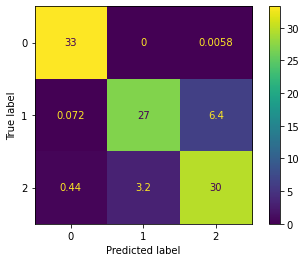

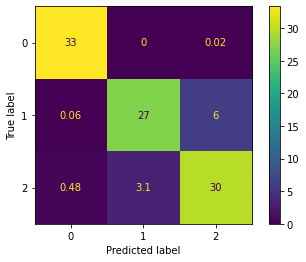

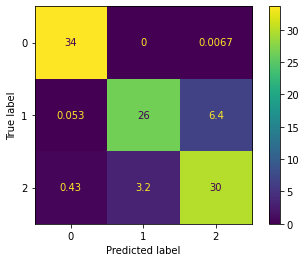

In [41]:
for cm in [confusion_matrix_train, confusion_matrix_val, confusion_matrix_test]:
    disp = ConfusionMatrixDisplay(confusion_matrix=((cm / cm.sum()) * 100), display_labels=[0, 1, 2])
    disp.plot()
    plt.show()

In [43]:
print(auc_train, auc_val, auc_test)

0.973199392543257 0.9745041292413631 0.9728215065121569
